In [485]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

from torchts.nn.loss import quantile_loss
from torchts.nn.model import TimeSeriesModel

from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility

In [2]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Generate data

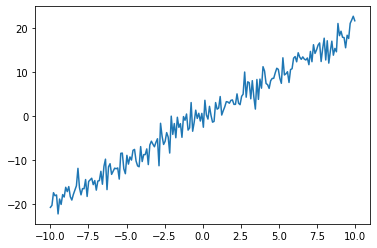

In [400]:
# generate linear time series data with some noise
n = 200
x_max = 10
slope = 2
scale = 2

x = torch.from_numpy(np.linspace(-x_max, x_max, n).reshape(-1, 1).astype(np.float32))
y = slope * x + np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)

plt.plot(x, y)
plt.show()

### Split data set

In [401]:
# # Split our training dataset into training and calibration sets randomly
# # and correct to maintain the timeseries convention of ascending x
# idx = np.random.permutation(n)
# n_half = int(np.floor(n/2))
# idx_train, idx_cal = np.sort(idx[:n_half]), np.sort(idx[n_half:2*n_half])

# # Perform split using our split indices
# x_train = x.numpy()[idx_train]
# x_cal = x.numpy()[idx_cal]

# y_train = y.numpy()[idx_train]
# y_cal = y.numpy()[idx_cal]

# plt.plot(torch.tensor(x_train), torch.tensor(y_train))
# plt.show()

# plt.plot(torch.tensor(x_cal), torch.tensor(y_cal))
# plt.show()

# x_train = torch.tensor(x_train)
# y_train = torch.tensor(y_train)
# x_cal = torch.tensor(x_cal)
# y_cal = torch.tensor(y_cal)

In [402]:
# split to three sections
window_size = n//3
if n % 3 == 0:
    # If an even split of data, then give each dataset n//3 entries
    x_train = x[:window_size]
    x_cal = x[window_size:window_size*2]
    x_test = x[window_size*2:]
    y_train = y[:window_size]
    y_cal = y[window_size:window_size*2]
    y_test = y[window_size*2:]
elif n % 3 == 1:
    # if there's 1 left, it automatically gets added to the test set
    x_train = x[:window_size]
    x_cal = x[window_size:window_size*2]
    x_test = x[window_size*2:]
    y_train = y[:window_size]
    y_cal = y[window_size:window_size*2]
    y_test = y[window_size*2:]
elif n % 3 == 2:
    # if there's 2 extra data points, add one to calibration, then other extra will go towards test
    x_train = x[:window_size]
    x_cal = x[window_size:window_size*2+1]
    x_test = x[window_size*2:]
    y_train = y[:window_size]
    y_cal = y[window_size:window_size*2+1]
    y_test = y[window_size*2:]

In [486]:
scaler = StandardScaler()


# Scale the y data locally (ex. train scaled to train)
y_train_scaled = scaler.fit_transform(y_train)
y_cal_scaled = scaler.fit_transform(y_cal)
y_test_scaled = scaler.fit_transform(y_test)

# scaler.fit(y_train)
# # Scale based on training set
# y_train_scaled = scaler.transform(y_train)
# y_cal_scaled = scaler.transform(y_cal)
# y_test_scaled = scaler.transform(y_test)


# Scale the x data locally (ex. train scaled to train)
x_train_scaled = scaler.fit_transform(x_train)
x_cal_scaled = scaler.fit_transform(x_cal)
x_test_scaled = scaler.fit_transform(x_test)

# Convert our scaled data into tensors of type float since that is what our torchTS model expects
y_train = torch.tensor(y_train_scaled).float()
y_cal = torch.tensor(y_cal_scaled).float()
y_test = torch.tensor(y_test_scaled).float()

x_train = torch.tensor(x_train_scaled).float()
x_cal = torch.tensor(x_cal_scaled).float()
x_test = torch.tensor(x_test_scaled).float()

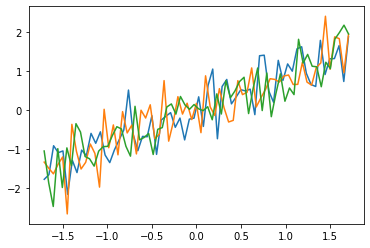

In [487]:
# Plot all 3 scaled datasets on top of each other
plt.plot(x_train, y_train_scaled)
plt.plot(x_cal, y_cal_scaled)
plt.plot(x_test, y_test_scaled)
plt.show()

# Define model that predicts quantiles

In [465]:
class QuantileLSTM(TimeSeriesModel):
    def __init__(
        self, input_size, output_size, hidden_size, optimizer, quantile=0.5, **kwargs
    ):
        super().__init__(
            optimizer,
            criterion=quantile_loss,
            criterion_args={"quantile": quantile},
            **kwargs
        )
        n_quantiles = 1 if isinstance(quantile, float) else len(quantile)
        self.lstm = nn.ModuleList(
            [nn.LSTMCell(input_size, hidden_size) for _ in range(output_size)]
        )
        self.linear = nn.ModuleList(
            [nn.Linear(hidden_size, n_quantiles) for _ in range(output_size)]
        )

    def forward(self, x, y=None, batches_seen=None):
        hidden, _ = zip(*[m(x) for m in self.lstm])
        out = [m(h) for m, h in zip(self.linear, hidden)]
        return torch.hstack(out)

In [466]:
input_size = 1
output_size = 1
hidden_size = 16
quantile = 0.5
optimizer = optim.Adam
optimizer_args = {"lr": 0.005}
max_epochs = 100
batch_size = 10

model = QuantileLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    quantile=quantile,
    optimizer_args=optimizer_args,
)

# Train model to predict a single quantile

In [467]:
# # train model
# model.fit(x_train, y_train, max_epochs=max_epochs, batch_size=batch_size)
# # model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)
# # inference
# y_cal_preds = model.predict(x_cal)

In [468]:
# plt.plot(x_cal, y_cal, label="y_true")
# plt.plot(x_cal, y_cal_preds, label=f"p={quantile}")
# plt.legend()
# plt.show()

# Train model to predict multiple quantiles

In [469]:
quantile = [0.025, 0.5, 0.975]

model = QuantileLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    quantile=quantile,
    optimizer_args=optimizer_args,
)

In [470]:
# train model
model.fit(x_train, y_train, max_epochs=max_epochs, batch_size=batch_size)
# model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)
# inference
y_cal_preds = model.predict(x_cal)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\mlabr\anaconda3\envs\spatiotemporal\lib\site-packages\pytorch_lightning\trainer\trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(
C:\Users\mlabr\anaconda3\envs\spatiotemporal\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 1.2 K 
1 | linear | ModuleList | 51    
--------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
C:\Users\mlabr\anaconda3\en

Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 250.02it/s, loss=0.221, v_num=13, train_loss_step=0.194, train_loss_epoch=0.222]


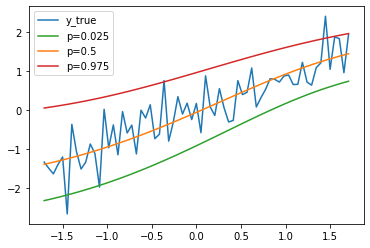

In [471]:
# n_quantiles = len(quantile)
# cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# color_index = [2, 1, 3]

# plt.plot(x, y, label="y_true")

# for i, c in zip(range(n_quantiles), color_index):
#     plt.plot(x, y_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

# plt.legend()
# plt.show()

n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x_cal, y_cal, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_cal, y_cal_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

plt.legend()
plt.show()

### Begin implementation of conformal prediction code

In [472]:
def quantile_err(prediction, y):
    """
    prediction: arr where first 3 columns are: lower quantile, middle quantile (50%), upper quantile in that order
    """
    y_lower = prediction[:, 0]
    y_upper = prediction[:, 2]
    # Calculate error on our predicted upper and lower quantiles
    # this will get us an array of negative values with the distance between the upper/lower quantile and the
    # 50% quantile
    error_low = y_lower - y
    error_high = y - y_upper
    # Make an array where each entry is the highest error when comparing the upper and lower bounds for that entry prediction 
    err = np.maximum(error_high, error_low)
    return err

In [473]:
# Find quantile error of our model
quantile_err(y_cal_preds, y_cal[:, 0])

tensor([-0.9884, -0.8020, -0.6318, -0.8451, -1.0066,  0.4861, -0.5337, -1.0501,
        -0.5677, -0.7050, -1.1292, -0.8584,  0.0432, -0.3137, -0.8871, -0.7689,
        -0.6226, -0.4838, -1.0601, -0.8884, -0.4669, -0.5669, -0.7984, -0.4909,
        -0.6629, -0.7301,  0.0322, -0.4465, -0.8812, -0.4802, -0.9610, -0.7164,
        -0.7286, -0.7909, -0.2801, -0.1513, -0.8274, -0.5503, -0.5838, -0.6352,
        -0.2095, -0.1937, -0.5166, -0.7395, -0.7425, -0.2909, -0.2526, -0.4333,
        -0.5907, -0.6972, -0.7417, -0.6204, -0.7207, -0.6993, -0.4062, -0.3613,
        -0.4859, -0.3269, -0.2034, -0.6104, -0.6080,  0.5635, -0.4464, -0.0153,
        -0.0846, -0.2519, -0.0223])

In [474]:
# store our quantile errors into variable named for calibration scores
cal_scores = quantile_err(y_cal_preds, y_cal[:, 0])

In [475]:
# Make a dictionary where our calibration scores (errors) are sorted in descending order
nc = {0: np.sort(cal_scores, 0)[::-1]}

In [476]:
# Specify significance we would like to see for our coverage when dealing with conformal prediction
significance = .1

In [477]:
# Sort calibration scores in ascending order? TODO make sure this is correct
# this is the apply_inverse portion of RegressorNC predict function
nc = np.sort(cal_scores,0)

index = int(np.ceil((1-significance) * (nc.shape[0] + 1))) - 1
# find largest error that gets us guaranteed coverage
index = min(max(index, 0), nc.shape[0] - 1)

err_dist = np.vstack([nc[index], nc[index]])

In [478]:
index

61

In [479]:
err_dist

array([[-0.02230489],
       [-0.02230489]], dtype=float32)

In [480]:
# store the predictions from our nonconformal quantile regressor
prediction = y_cal_preds

In [481]:
intervals = np.zeros((x_cal.shape[0],3))
# TODO ensure that we want to multiply our error distances by the size of our training set
err_dist = np.hstack([err_dist] * x_cal.shape[0])

In [482]:
prediction.shape

torch.Size([67, 3])

In [483]:
# CQR

# grab the first and last intervals predicted from our nonconformal quantile regressor in order to
# calculate our new intervals that fit our coverage requirements
intervals[:, 0] = prediction[:,0] - err_dist[0, :]
intervals[:, 1] = prediction[:,1]
intervals[:, 2] = prediction[:, -1] + err_dist[1,:]

conformal_intervals = intervals

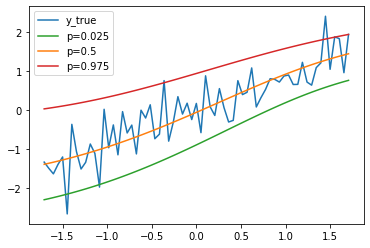

In [484]:
# n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x_cal, y_cal, label="y_true")

for i, c in zip(range(len(conformal_intervals)), color_index):
    plt.plot(x_cal, conformal_intervals[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

plt.legend()
plt.show()

# End of conformal implementation

# Add second response variable

In [456]:
# y_max = slope * x_max
# y2 = 2 * y_max / (1 + np.exp(-x)) - y_max
# y2 += np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)
# y = torch.hstack([y, y2])

# plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
# plt.plot(x, y[:, 0])
# plt.subplot(1, 2, 2)
# plt.plot(x, y[:, 1])
# plt.show()

# Train model to predict quantiles for two response variables

In [27]:
# output_size = 2

# model = QuantileLSTM(
#     input_size,
#     output_size,
#     hidden_size,
#     optimizer,
#     quantile=quantile,
#     optimizer_args=optimizer_args,
# )

In [28]:
# # train model
# model.fit(x, y, max_epochs=max_epochs, batch_size=batch_size)

# # inference
# y_preds = model.predict(x)

In [29]:
# plt.figure(figsize=(12, 4))

# plt.subplot(1, 2, 1)
# plt.plot(x, y[:, 0], label="y_true")

# for i, c in zip(range(n_quantiles), color_index):
#     plt.plot(x, y_preds[:, i], c=cycle_colors[c], label=f"p={quantile[i]}")

# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(x, y[:, 1], label="y_true")

# for i, c in zip(range(n_quantiles), color_index):
#     plt.plot(x, y_preds[:, i + n_quantiles], c=cycle_colors[c], label=f"p={quantile[i]}")

# plt.legend()

# plt.show()